In [2]:
import hopsworks
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from matplotlib import pyplot
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib
import os

/Users/wasp/Documents/kth/scalable-ml-dl/id2223-scalable-machine-learning/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import os
 
for k, v in os.environ.items():
    if "HOPS" in k:
        print(f'{k}={v}')

In [4]:
# You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/185496
Connected. Call `.close()` to terminate connection gracefully.


In [50]:
# The feature view is the input set of features for your model. The features can come from different feature groups.    
# You can select features from different feature groups and join them together to create a feature view

# FEATURE_GROUPS = [2, 3]

# wine_fgs = [fs.get_feature_group(name="wine", version=x) for x in FEATURE_GROUPS]

wine_fg = fs.get_feature_group(name="wine", version=2)

# without citric acid it performs better
query = wine_fg.select_except(["citric_acid"])
# query = wine_fg.select_all()
feature_view = fs.get_or_create_feature_view(name="wine",
                                version=7,
                                description="Read from Wine quality dataset",
                                labels=["quality"],
                                query=query)

# feature_views = []
# for i, fg in enumerate(wine_fgs, FEATURE_GROUPS[0]):
#     query = fg.select_all()
#     feature_views.append(fs.get_or_create_feature_view(name="wine",
#                                     version=i,
#                                     description="Read from Wine quality dataset",
#                                     labels=["quality"],
#                                     query=query))

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/185496/fs/185415/fv/wine/version/7


In [96]:
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import time

# You can read training data, randomly split into train/test sets of features (X) and labels (y)        

models = [
    tree.DecisionTreeClassifier(),
    LinearRegression(),
    KNeighborsClassifier(n_neighbors=6),
    RandomForestClassifier(),
    RandomForestClassifier(n_estimators=200),
    RandomForestClassifier(n_estimators=600),
    RandomForestClassifier(max_depth=10, n_estimators=200),
]

scores = [0] * len(models)
scores = [0] * len(models)
runs = 10

X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)

for _ in range(runs):
    for i, m in enumerate(models):
        start = time.time()
        m = m.fit(X_train, y_train.values.ravel())
        stop = time.time() - start
        score = m.score(X_test, y_test)
        scores[i] += score
        print(m, score, stop)

# get the average score for each model
for i, score in enumerate(scores):
    scores[i] = score / runs

print("scores", scores)

# get the best model
best_model = models[scores.index(max(scores))]
print("Best model:", best_model)

# best result: RandomForestClassifier(n_estimators=200)

# # train our model with linear regression algorithm
# for i, fv in enumerate(feature_views, FEATURE_GROUPS[0]):
#     print("fv", i)
#     X_train, X_test, y_train, y_test = fv.train_test_split(0.2)
#     for model in models:
#         model = model.fit(X_train, y_train.values.ravel())
#         print(model, model.score(X_test, y_test))
#     print()

# Evaluate the model
# print("Accuracy: {}".format(accuracy_score(y_test, pred_labels)))
# print("Confusion matrix: \n{}".format(confusion_matrix(y_test, pred_labels)))
# print("Classification report: \n{}".format(classification_report(y_test, pred_labels)))


Finished: Reading data from Hopsworks, using ArrowFlight (1.27s) 


DecisionTreeClassifier() 0.47462406015037595 0.05239605903625488
LinearRegression() 0.3496035062575594 0.004104137420654297
KNeighborsClassifier(n_neighbors=6) 0.4426691729323308 0.001703023910522461
RandomForestClassifier() 0.5582706766917294 0.5781121253967285
RandomForestClassifier(n_estimators=200) 0.5639097744360902 1.0063738822937012
RandomForestClassifier(n_estimators=600) 0.5714285714285714 2.991034746170044
RandomForestClassifier(max_depth=10, n_estimators=200) 0.5516917293233082 0.7455158233642578
DecisionTreeClassifier() 0.4906015037593985 0.022691011428833008
LinearRegression() 0.3496035062575594 0.0015749931335449219
KNeighborsClassifier(n_neighbors=6) 0.4426691729323308 0.001500844955444336
RandomForestClassifier() 0.5601503759398496 0.5683119297027588
RandomForestClassifier(n_estimators=200) 0.5545112781954887 0.9766299724578857
RandomForestClassifier(n_estimators=600) 0.5657894736842105 2.941438913345337
RandomForestClassifier(max_depth=10, n_estimators=200) 0.550751879

In [101]:
# best result: RandomForestClassifier(n_estimators=600)
# it's much slower than the others but that doesn't matter in this case

model = RandomForestClassifier(n_estimators=600)
model = model.fit(X_train, y_train.values.ravel())

In [102]:
# Evaluate model performance using the features from the test set (X_test)
print("y_pred")
y_pred = model.predict(X_test)

# Compare predictions (y_pred) with the labels in the test set (y_test)
print("metrics")
metrics = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
print(metrics)
print("results")
results = confusion_matrix(y_test, y_pred)

y_pred
metrics
{'3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1}, '4': {'precision': 0.5, 'recall': 0.09302325581395349, 'f1-score': 0.15686274509803924, 'support': 43}, '5': {'precision': 0.6455331412103746, 'recall': 0.6103542234332425, 'f1-score': 0.627450980392157, 'support': 367}, '6': {'precision': 0.53, 'recall': 0.7327188940092166, 'f1-score': 0.6150870406189556, 'support': 434}, '7': {'precision': 0.6571428571428571, 'recall': 0.3612565445026178, 'f1-score': 0.46621621621621623, 'support': 191}, '8': {'precision': 0.75, 'recall': 0.1111111111111111, 'f1-score': 0.19354838709677416, 'support': 27}, '9': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1}, 'accuracy': 0.5808270676691729, 'macro avg': {'precision': 0.4403822854790331, 'recall': 0.27263771841002027, 'f1-score': 0.29416648134602025, 'support': 1064}, 'weighted avg': {'precision': 0.5960478839647493, 'recall': 0.5808270676691729, 'f1-score': 0.5622560970119119, 'support': 1064}}
res

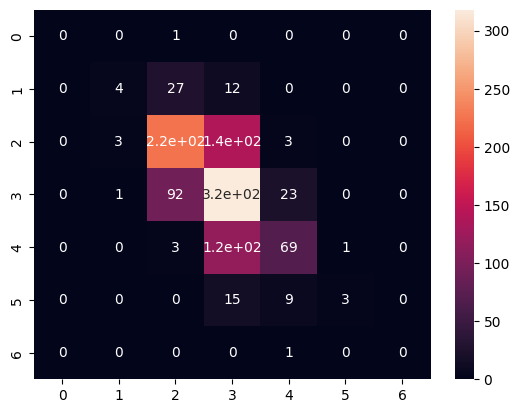

In [103]:
# Create the confusion matrix as a figure, we will later store it as a PNG image file
df_cm = pd.DataFrame(results)
cm = sns.heatmap(df_cm, annot=True)
fig = cm.get_figure()

In [104]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'wine_model' directory will be saved to the model registry. Create the dir, first.
model_dir="wine_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(model, model_dir + "/wine_model.pkl")
fig.savefig(model_dir + "/confusion_matrix.png")    

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
wine_model = mr.python.create_model(
    name="wine_model", 
    metrics={"accuracy" : metrics['accuracy']},
    model_schema=model_schema,
    description="Wine Quality Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
wine_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


Uploading: 100.000%|██████████| 23350/23350 elapsed<00:01 remaining<00:001,  2.98it/s]
Uploading: 100.000%|██████████| 148580881/148580881 elapsed<01:19 remaining<00:00it/s]
Uploading: 100.000%|██████████| 992/992 elapsed<00:01 remaining<00:00<03:12, 48.03s/it]
Model export complete: 100%|██████████| 6/6 [01:29<00:00, 14.88s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/185496/models/wine_model/2


Model(name: 'wine_model', version: 2)